In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from collections import OrderedDict
import pickle
import pickle5
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score   
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.utils import resample
from pysurvival.models.semi_parametric import CoxPHModel

## block warning
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open("../data/ut_poiV6.pkl", "rb") as fh:
    df = pickle5.load(fh)
    
df.head()

,life_time,datetime_start,datetime_end,latitude,longitude,distance_center_km,Station_Name,weekday_b,weekday_b_name,hour_b,...,near_inactivity_6H,near_charge_events_6H,service,entertainment,food,childcare,medical,education,parking,waste-management
0,928.5,2018-01-31 19:51:00,2018-02-01 11:19:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,2,Wednesday,19,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
1,363.5,2018-02-01 14:03:00,2018-02-01 20:06:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,14,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
2,6828.5,2018-02-01 21:15:00,2018-02-06 15:03:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,3,Thursday,21,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
3,5871.5,2018-02-06 15:27:00,2018-02-10 17:18:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,1,Tuesday,15,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959
4,1454.5,2018-02-10 18:26:00,2018-02-11 18:40:30,40.018482,-105.281066,0.152203,COMM VITALITY / 1104 SPRUCE1,5,Saturday,18,...,0.0,0,0.057343,0.109796,0.073649,3.517121,0.466518,0.631771,0.021832,1.145959


### Remove events

In [3]:
names = df['Station_Name'].unique()

for name in names:
    temp = df[df['Station_Name'] == name]
    rows = temp[temp['lag3'].isna()]
    if rows.life_time.sum() < 3*60:
        print("The station has the lagged")
        print(name)

# remove rows
df = df.dropna()

The station has the lagged
BOULDER / REC CENTER
The station has the lagged
BOULDER / ATRIUM ST1
The station has the lagged
BOULDER / ALPINE ST1
The station has the lagged
COMM VITALITY / 1400 WALNUT1
The station has the lagged
BOULDER / FACILITIES ST1
The station has the lagged
COMM VITALITY / 1500PEARL
The station has the lagged
BOULDER / JUNCTION ST1
The station has the lagged
COMM VITALITY / BOULDER JCTN
The station has the lagged
COMM VITALITY / 1100WALNUT1
The station has the lagged
BOULDER / BOULDER PARK
The station has the lagged
COMM VITALITY / 2200 BROADWAY1
The station has the lagged
BOULDER / EAST REC
The station has the lagged
BOULDERJUNCTION / JUNCTION ST1


In [4]:
df.shape

(12699, 71)

In [5]:
## Limit to only top 10 stations
temp = df.groupby(['Station_Name']).count().latitude # group the data for each station
names = temp.sort_values(ascending=False)
names = names.index.values

In [6]:
stat4 = names[0:4]
single_stat1 = 'COMM VITALITY / 1400 WALNUT1'
single_stat2 = 'BOULDER / ALPINE ST1'

### Remove outliers

In [7]:
# remove outliers
drop_index = [] # list of indexes to keep
names = df['Station_Name'].unique()

for name in names:
    temp = df[df['Station_Name'] == name]
    # Get interquantile ranges
    Q1, Q3 = temp.life_time.quantile([0.25, 0.75])
    IQR = Q3-Q1
    minimum = Q1 - 1.5*IQR
    maximum = Q3 + 1.5*IQR
    # Define observations which should be removed
    temp2 = df[(df['life_time'] < minimum) | (df['life_time'] > maximum) &
                  (df['Station_Name'] == name)]
    print("{n}: {s} ({p} %)".format(n=name, 
                                    s=temp2.shape[0], 
                                    p=round((temp2.shape[0]/temp.shape[0])*100,2)))
    # Add the indexes which should be dropped
    drop_index.extend(list(temp2.index))
    
print("\nThe total amount of lost events: {n} ({p} %)".format(n=len(drop_index), 
                                                              p=round(len(drop_index)/df.shape[0]*100,2)))

df = df.drop(drop_index)
df = df.reset_index(drop=True)

COMM VITALITY / 1104 SPRUCE1: 57 (4.4 %)
COMM VITALITY / 1000WALNUT: 48 (3.32 %)
BOULDER / REC CENTER: 40 (3.51 %)
BOULDER / BASELINE ST1: 42 (3.53 %)
BOULDER / ATRIUM ST1: 65 (6.58 %)
BOULDER / ALPINE ST1: 32 (8.96 %)
COMM VITALITY / 1400 WALNUT1: 38 (7.29 %)
BOULDER / FACILITIES ST1: 84 (16.28 %)
COMM VITALITY / 1500PEARL: 41 (4.5 %)
BOULDER / JUNCTION ST1: 35 (9.97 %)
COMM VITALITY / BOULDER JCTN: 40 (5.28 %)
COMM VITALITY / 1100WALNUT1: 39 (3.51 %)
BOULDER / N BOULDER REC 1: 29 (2.07 %)
BOULDER / BOULDER PARK: 8 (4.55 %)
COMM VITALITY / 2200 BROADWAY1: 0 (0.0 %)
BOULDER / EAST REC: 23 (5.42 %)
BOULDERJUNCTION / JUNCTION ST1: 3 (3.0 %)

The total amount of lost events: 624 (4.91 %)


In [8]:
df.shape

(12075, 71)

### Usefull functions

In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [10]:
## To test model
def test_model(y_test, y_pred):
    MAE = metrics.mean_absolute_error(y_test, y_pred)
    MSE = metrics.mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    NRMSE = RMSE/np.mean(y_test)
    return MAE, RMSE, MSE, MAPE, NRMSE

### Prepare data

In [11]:
def hour_label(X):
    if (X >= 7) & (X <= 10):
        return 'Morning'
    elif (X >= 11) & (X <= 14):
        return 'Midday'
    elif (X >= 15) & (X <= 18):
        return 'Afternoon'
    elif (X >= 19) or (X < 1):
        return 'Evening'
    elif (X >= 1) & (X <= 6):
        return 'Night'

In [12]:
## Add time of day and day of week
df['tod'] = df['hour_b'].apply(hour_label)

In [13]:
df = df[df['tod'] != 'Night']

In [14]:
station_subset = ['BOULDER / N BOULDER REC 1', 'COMM VITALITY / 1000WALNUT', 
        'COMM VITALITY / 1104 SPRUCE1', 'BOULDER / BASELINE ST1']
df4 = df[df['Station_Name'].isin(station_subset)]
dfSingle1 = df[df['Station_Name'] == single_stat1]
dfSingle2 = df[df['Station_Name'] == single_stat2]

In [15]:
print("Shape df 4 station:", df4.shape)
print("Shape of single1:", dfSingle1.shape)
print("Shape of single2:", dfSingle2.shape)

Shape df 4 station: (5110, 72)
Shape of single1: (481, 72)
Shape of single2: (297, 72)


Add dummy variables

In [16]:
# Categorical features
columns_categorical = ['weekday_b_name','tod','Station_Name']
df4 = pd.get_dummies(df4, columns=columns_categorical)
columns_categorical = ['weekday_b_name','tod']
dfSingle1 = pd.get_dummies(dfSingle1, columns=columns_categorical)
dfSingle2 = pd.get_dummies(dfSingle2, columns=columns_categorical)

In [17]:
df4 = df4.sort_values(by=['datetime_start'])
dfSingle1 = dfSingle1.sort_values(by=['datetime_start'])
dfSingle2 = dfSingle2.sort_values(by=['datetime_start'])

Features

M4 is used as the name for the Full features constellation throughout the notebook.

In [18]:
features4_cat_TEMP = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
                 'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
                 'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday',
                 'weekday_b_name_Friday',
                 'tod_Evening','tod_Midday', 'tod_Morning', 'tod_Afternoon',
                 'Station_Name_BOULDER / N BOULDER REC 1',
                 'Station_Name_COMM VITALITY / 1000WALNUT',
                 'Station_Name_COMM VITALITY / 1104 SPRUCE1',
                'Station_Name_BOULDER / BASELINE ST1']

features4_cat = ['weekday_b_name_Monday', 'weekday_b_name_Saturday',
                 'weekday_b_name_Sunday', 'weekday_b_name_Thursday',
                 'weekday_b_name_Tuesday', 'weekday_b_name_Wednesday',
                 'tod_Evening','tod_Midday', 'tod_Morning',
                 'Station_Name_BOULDER / N BOULDER REC 1',
                 'Station_Name_COMM VITALITY / 1000WALNUT',
                 'Station_Name_COMM VITALITY / 1104 SPRUCE1']

features4_con = ['lag1', 'lag2', 'lag3','near_charge_time_4H', 'near_charge_energy_4H',
                 'charge_time_4H', 'charge_energy_4H','service', 'entertainment', 'food', 
                 'childcare', 'medical', 'education','parking', 'waste-management']  # dow + agg. tod + lag + activ.
temporal_features = ['service', 'entertainment', 'food', 
                 'childcare', 'medical', 'education','parking', 'waste-management']

In [19]:
split = 0.8

train4, test4 = np.split(df4, [int(split * len(df4))])

In [20]:
split = 0.8

## Get X and y - M5
X = train4[features4_cat+features4_con]
y = train4['life_time']

## split data
X_train4, X_test4 = np.split(X, [int(split * len(X))])
y_train4, y_test4 = np.split(y, [int(split * len(X))])

## Standardize
scaler = StandardScaler()
X_train4[features4_con] = scaler.fit_transform(X_train4[features4_con])
X_test4[features4_con] = scaler.transform(X_test4[features4_con])

# Single-Step - predict new station

The first experiment is to see how the models can be used to understand vacancy times of a possible new station.

### Construct new dataset for "fictive" station
First we need to construct a data set for the new station. To do that we construct a dataset. We choose a station that is also in the dataset but not on of the 4 used station. As an example we choose `COMM VITALITY / 1400 WALNUT1` as this station has similar characteristics as 1000WALNUT, it is on the same street but approximately 400 meters down the street. Therefore when modeling the 1000WALNUT feature is set to 1 when testing the features. The dataset is constructed with $7 \cdot 4$ events so one for each tod for every day. As we have no prior knowledge about the avtivity of previous events the continous features are set to the average.

In [21]:
days = ['weekday_b_name_Monday', 'weekday_b_name_Tuesday',
        'weekday_b_name_Wednesday', 'weekday_b_name_Thursday',
        'weekday_b_name_Friday', 'weekday_b_name_Saturday',
        'weekday_b_name_Sunday']
tod = ['tod_Morning', 'tod_Midday', 'tod_Afternoon', 'tod_Evening']

In [22]:
all_fea = features4_cat_TEMP + features4_con 
df_new = pd.DataFrame(columns=all_fea)

for d in days:
    for t in tod:
        temp = train4[(train4[d] == 1) & (train4[t] == 1)]
        temp2 = temp.mean()
        new_row = {}
        for fea in all_fea:
            new_row[fea] = temp2[fea]
        df_new = df_new.append(new_row, ignore_index=True)
        
## For the spatial features we need the correct distances and not mean values
for fea in temporal_features:
    dist = df[df['Station_Name'] == single_stat1][fea].unique()[0]
    df_new[fea] = [dist]*len(df_new)
    
# Set the nearest station
df_new['Station_Name_COMM VITALITY / 1000WALNUT'] = np.ones(len(df_new))

In [23]:
df_new.head(4)

,weekday_b_name_Monday,weekday_b_name_Saturday,weekday_b_name_Sunday,weekday_b_name_Thursday,weekday_b_name_Tuesday,weekday_b_name_Wednesday,weekday_b_name_Friday,tod_Evening,tod_Midday,tod_Morning,...,charge_time_4H,charge_energy_4H,service,entertainment,food,childcare,medical,education,parking,waste-management
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.522801,8.149861,0.040945,0.184508,0.124113,3.353541,0.04327,0.47398,0.01983,0.73688
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.671369,9.209298,0.040945,0.184508,0.124113,3.353541,0.04327,0.47398,0.01983,0.73688
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.603297,8.576115,0.040945,0.184508,0.124113,3.353541,0.04327,0.47398,0.01983,0.73688
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.685833,10.905615,0.040945,0.184508,0.124113,3.353541,0.04327,0.47398,0.01983,0.73688


In [25]:
# scale continous features
df_new[features4_con] = scaler.transform(df_new[features4_con])

Specify hyper parameters

In [27]:
params = {}
params['M1'] = {}
params['M4'] = {}
params['M1']['LR'] = {'alpha':15}
params['M4']['LR'] = {'alpha':15}
params['M1']['RF'] = {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_depth': 7}
params['M4']['RF'] = {'n_estimators': 500, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_depth': 7}
params['M1']['MLP'] = {'hidden_layer_sizes': (128, 128, 128, 128), 'alpha': 0.001, 'activation': 'relu'}
params['M4']['MLP'] = {'hidden_layer_sizes': 256, 'alpha': 0.001, 'activation': 'relu'}
params['M1']['GB'] = {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 2, 'learning_rate': 0.5}
params['M4']['GB'] = {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_depth': 3, 'learning_rate': 0.01}

### Quantile regression

In [32]:
quantile_labels = ['5%','25%','50%','75%','95%']
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
qr_M4 = pd.DataFrame(columns=quantile_labels)

In [33]:
for i in range(len(quantiles)):
    reg = GradientBoostingRegressor(random_state=42, max_depth=3,
                                        n_estimators=500, 
                                        learning_rate=0.01,
                                        min_samples_split=5,
                                        min_samples_leaf=5,
                                        loss='quantile', alpha=quantiles[i])
    reg.fit(X_train4,y_train4)
    qr_M4[quantile_labels[i]] = reg.predict(df_new[features4_cat+features4_con])

In [34]:
qr_M4.head()

,5%,25%,50%,75%,95%
0,13.500143,74.971653,149.766328,380.476120,1326.413155
1,13.523750,73.383762,172.892027,333.635818,1328.710885
2,14.585994,69.474598,181.268106,878.704738,1309.923853
3,36.545230,593.942553,726.107655,871.227704,1286.794639
4,13.947013,70.875220,132.979539,379.275688,1271.754717


In [35]:
df_new_QR = df_new.merge(qr_M4, left_index=True, right_index=True)

In [36]:
df_new_QR.head()

,weekday_b_name_Monday,weekday_b_name_Saturday,weekday_b_name_Sunday,weekday_b_name_Thursday,weekday_b_name_Tuesday,weekday_b_name_Wednesday,weekday_b_name_Friday,tod_Evening,tod_Midday,tod_Morning,...,childcare,medical,education,parking,waste-management,5%,25%,50%,75%,95%
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.421343,-1.199019,-0.783021,-0.933516,0.001492,13.500143,74.971653,149.766328,380.476120,1326.413155
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.421343,-1.199019,-0.783021,-0.933516,0.001492,13.523750,73.383762,172.892027,333.635818,1328.710885
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.421343,-1.199019,-0.783021,-0.933516,0.001492,14.585994,69.474598,181.268106,878.704738,1309.923853
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.421343,-1.199019,-0.783021,-0.933516,0.001492,36.545230,593.942553,726.107655,871.227704,1286.794639
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.421343,-1.199019,-0.783021,-0.933516,0.001492,13.947013,70.875220,132.979539,379.275688,1271.754717


In [37]:
tods = ['tod_Morning', 'tod_Midday', 'tod_Afternoon', 'tod_Evening']

## Get mean and standard deviation of each quantile and TOD combination
results_mean = pd.DataFrame(columns=quantile_labels, index=tods)
results_std = pd.DataFrame(columns=quantile_labels, index=tods)
for t in tods:
    temp = df_new_QR[df_new_QR[t] == 1]
    for q in quantile_labels:
        temp2 = temp[q]
        results_mean.loc[t][q] = np.mean(temp2.values)
        results_std.loc[t][q] = np.std(temp2.values)

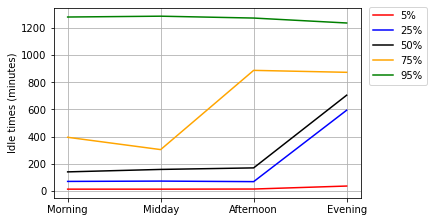

In [38]:
colors = ['red','blue','black','orange','green']
tods_labels = ['Morning','Midday','Afternoon','Evening']

fig = plt.figure(figsize=(5.5, 3.5))



for i in range(len(quantile_labels)):
    q = quantile_labels[i] # get the quantile label
    plt.plot(tods_labels,results_mean[q], color=colors[i], label=q)

plt.legend(bbox_to_anchor=(1.01,1.03), loc="upper left")
plt.ylabel("Idle times (minutes)")
plt.grid()
plt.savefig('../visualization/QR_TOD_NewStation.pdf',bbox_inches='tight')
plt.show()

### Survival analysis

In [40]:
## Get point predictions
def point_pred(model, X_test, X_train):
    T_pred = []
    T_pred_train = []
    # Get survival curves
    cph_pred = model.predict_survival(X_test)
    cph_pred_train = model.predict_survival(X_train)
    # get times of survival prediction
    time = model.times
    # test
    for i in range(0,len(cph_pred)):
        T_pred.append(auc(time,cph_pred[i]))
    # train
    for i in range(0,len(cph_pred_train)):
        T_pred_train.append(auc(time,cph_pred_train[i]))
    
    return T_pred, T_pred_train

Split the data for survival analysis

In [41]:
df4.head()

,life_time,datetime_start,datetime_end,latitude,longitude,distance_center_km,weekday_b,hour_b,charging_ports,lag1,...,weekday_b_name_Tuesday,weekday_b_name_Wednesday,tod_Afternoon,tod_Evening,tod_Midday,tod_Morning,Station_Name_BOULDER / BASELINE ST1,Station_Name_BOULDER / N BOULDER REC 1,Station_Name_COMM VITALITY / 1000WALNUT,Station_Name_COMM VITALITY / 1104 SPRUCE1
3734,118.5,2018-01-05 14:25:00,2018-01-05 16:23:30,40.000148,-105.282437,2.096847,4,14,2,1271.5,...,0,0,0,0,1,0,1,0,0,0
3735,886.5,2018-01-05 17:02:00,2018-01-06 07:48:30,40.000148,-105.282437,2.096847,4,17,2,118.5,...,0,0,1,0,0,0,1,0,0,0
3736,326.5,2018-01-06 09:28:00,2018-01-06 14:54:30,40.000148,-105.282437,2.096847,5,9,2,886.5,...,0,0,0,0,0,1,1,0,0,0
3737,996.5,2018-01-06 17:09:00,2018-01-07 09:45:30,40.000148,-105.282437,2.096847,5,17,2,326.5,...,0,0,1,0,0,0,1,0,0,0
3738,52.5,2018-01-07 10:58:00,2018-01-07 11:50:30,40.000148,-105.282437,2.096847,6,10,2,996.5,...,0,0,0,0,0,1,1,0,0,0


In [42]:
X_train = df4[features4_cat+features4_con]
T_train = df4['life_time']
E_train = np.ones(len(df4))

reg = CoxPHModel()
reg.fit(X_train, T_train, E_train, lr= 0.1, l2_reg=0.1, init_method='zeros', max_iter=800, verbose=False)

CoxPHModel

In [43]:
surv = reg.predict_survival(x=df_new[features4_cat+features4_con])
time = reg.times

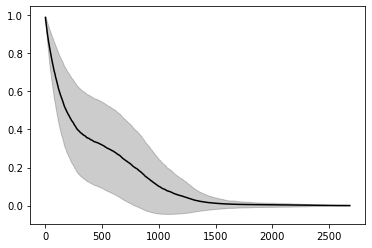

In [44]:
mean = []
upper = []
lower = []

N = 2

for k in range(len(time)):
    vals = surv[:,k]
    mean.append(np.mean(vals))
    std_ = np.std(vals)
    upper.append(np.mean(vals)+std_*N)
    lower.append(np.mean(vals)-std_*N)
    
plt.fill_between(x=time, y1=lower, y2=upper, alpha=0.2, color='k')
plt.plot(time,mean, color='k')
plt.show()

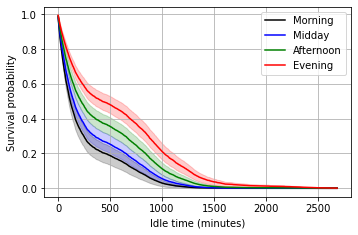

In [47]:
fig = plt.figure(figsize=(5.5, 3.5))

mean = {}
upper = {}
lower = {}

temp = df_new[features4_cat+features4_con]

N = 2

for t in tod:
    idx = df_new[df_new[t] == 1].index
    temp_surv = surv[idx]
    
    temp_mean = []
    temp_upper = []
    temp_lower = []
    for k in range(len(time)):
        vals = temp_surv[:,k]
        temp_mean.append(np.mean(vals))
        std_ = np.std(vals)
        temp_upper.append(np.mean(vals)+std_*N)
        temp_lower.append(np.mean(vals)-std_*N)
        
    mean[t] = temp_mean
    lower[t] = temp_lower
    upper[t] = temp_upper

tod_color = ['k','b','g','r']
tod_label = ['Morning','Midday','Afternoon','Evening']
for i in range(len(tod)):
    plt.plot(time,mean[tod[i]], color=tod_color[i], label=tod_label[i])
    plt.fill_between(x=time, y1=lower[tod[i]], y2=upper[tod[i]], color=tod_color[i],alpha=0.2)
plt.grid()
plt.xlabel("Idle time (minutes)")
plt.ylabel("Survival probability")
plt.legend()
plt.savefig('../visualization/SA_TOD_NewStation.pdf',bbox_inches='tight')
plt.show()

In [50]:
min_times = [30, 60, 120, 240, 480]

In [58]:
for t in tods:
    print(t)
    idx = df_new[df_new[t] == 1].index # get index for tod
    for tim in min_times:
        bob = reg.predict_survival(x=df_new[features4_cat+features4_con], t=tim)
        bob = bob[idx]
        print("{}:  {} ({})".format(tim,round(np.mean(bob),2),
                                    round(np.std(bob),2)))
    print("\n")
    



tod_Morning
30:  0.81 (0.01)
60:  0.68 (0.02)
120:  0.49 (0.03)
240:  0.31 (0.03)
480:  0.19 (0.03)


tod_Midday
30:  0.84 (0.01)
60:  0.73 (0.02)
120:  0.56 (0.02)
240:  0.38 (0.03)
480:  0.26 (0.03)


tod_Afternoon
30:  0.88 (0.01)
60:  0.79 (0.01)
120:  0.65 (0.02)
240:  0.48 (0.02)
480:  0.36 (0.03)


tod_Evening
30:  0.91 (0.01)
60:  0.84 (0.01)
120:  0.73 (0.02)
240:  0.6 (0.02)
480:  0.49 (0.02)


